Что дальше:
1. Провести заново работу по подбору факторов с учетом макс корр.
2. В той же логике построить прогнозы для ARIMA
3. Привести к "при прочих равных" сравниваемые ошибки в моделях.
4. добавить новостностой индес, сравнить модели

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from tqdm import tqdm

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Я скилывал два файла. Из второго файла тоже нужно использовать факторы.
macro_1 = pd.read_excel('data/rez_file_Y_v2.xlsx', parse_dates=['date'], index_col='date')
macro_2 = pd.read_excel('data/rez_file_X_v6.xlsx', parse_dates=['date'], index_col='date')
macro = pd.concat([macro_1, macro_2], axis=1)

In [7]:
ipp = pd.read_excel('data/iip_m12_2024.xlsx')
ipp['date'] = pd.date_range(start='2005-01-31', end='2024-12-31', freq='M')
ipp.drop(columns='Unnamed: 0', inplace=True)
ipp.set_index('date', inplace=True)

In [9]:
idx_path = 'news_idx.csv'
idx = pd.read_csv(idx_path)
idx['date'] = pd.to_datetime(idx['date'])
idx.set_index('date', drop=True, inplace=True)

In [11]:
bert = idx['BERT']
deepseek = idx['DEEPSEEK']
llama = idx['LLAMA']

In [14]:
target_dict = {    
    'Производство нефтепродуктов': 'Подраздел DF Производство кокса , нефтепродуктов и ядерных материалов',
    
    'Производство резины': 'Подраздел DH Производство резиновых и пластмассовых  изделий',
    
    'Химическое производство': 'Подраздел DG Химическое производство',    
}
inverse_d = {v: k for k, v in target_dict.items()}

**что происходит**:

данные чистятся от длинных пробелов, переводятся в численный формат

$get\_high\_corr\_features$ для заданного таргета отбирает признаки с корреляцией выше $threshold$, затем выкидывает признаки, между которыми корреляция выше $multicoll$

далее создается словарь с признаками для каждого таргета

In [20]:
def convert_to_float(value):
    if isinstance(value, float) or isinstance(value, int):
        return float(value)
    elif isinstance(value, str):
        # Заменяем неразрывный пробел на обычный
        cleaned = value.replace('\xa0', '')
        try:
            return float(cleaned)
        except ValueError:
            return np.nan
    else:
        return np.nan

object_columns = macro.select_dtypes(include=['object']).columns
macro[object_columns] = macro[object_columns].applymap(convert_to_float)

In [22]:
# в других столбцах пропусков > 62
columns_to_drop = macro.columns[macro.isna().sum() >= 50]
macro = macro.drop(columns=columns_to_drop)

In [24]:
# macro.isna().sum().sort_values()

In [26]:
def get_high_corr_features(macro_df, target, threshold=0.5, multicoll=.5):
    """
    Возвращает список признаков с корреляцией выше threshold по абсолютному значению с таргетом,
    исключая признаки с высокой взаимной корреляцией
    
    Параметры:
    df - DataFrame
    target - имя таргетного столбца или ключ в target_dict
    threshold - порог корреляции с таргетом (по умолчанию 0.5)
    """
# датафрейм с таргетом присоединяется по индексам таргета
    target_col = target_dict[target]
    
    target_df = ipp[[target_col]]
    df = target_df.merge(macro_df, left_index=True, right_index=True, how='left')
                      
    corr_matrix = df.corr()
    target_corr = corr_matrix[target_col].abs()
    
    # Отбираем признаки с высокой корреляцией с таргетом
    high_corr_features = target_corr[target_corr > threshold].drop(target_col, errors='ignore')
    
    # Если нет признаков с высокой корреляцией, возвращаем пустой DataFrame
    if high_corr_features.empty:
        print(f'No features with correlation > {threshold} for {target_col}')
        return pd.DataFrame()
    
    # Анализ взаимной корреляции между признаками
    features_to_keep = []
    features_to_check = high_corr_features.sort_values(ascending=False).index.tolist()
    
    # Создаем матрицу корреляции только для отобранных признаков
    features_corr = df[features_to_check].corr().abs()
    
    # Проходим по всем признакам и исключаем коррелирующие
    while features_to_check:
        # Берем признак с наибольшей корреляцией с таргетом
        current_feature = features_to_check.pop(0)
        features_to_keep.append(current_feature)
        
        # Находим признаки, которые сильно коррелируют с текущим
        correlated_features = features_corr.loc[current_feature][features_to_check]
        correlated_features = correlated_features[correlated_features > multicoll].index.tolist()
        
        # Удаляем их из списка для проверки
        for feature in correlated_features:
            if feature in features_to_check:
                features_to_check.remove(feature)
    
    # Создаем итоговый DataFrame с отобранными признаками
    result_df = df[features_to_keep]
    
    # Выводим информацию о корреляциях
    print(f'\nHigh correlations for {target_col} (after removing inter-correlated features):\n')
    print(high_corr_features[features_to_keep].sort_values(ascending=False).to_string())
    
    # Визуализация корреляционной матрицы
    plot_df = df[[target_col] + features_to_keep]
    plot_df = plot_df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(plot_df, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=.5)
    plt.title(f'Корреляция между признаками и целевой переменной {target_col}')
    plt.show()
    
    return result_df


High correlations for Подраздел DF Производство кокса , нефтепродуктов и ядерных материалов (after removing inter-correlated features):

ИПП в % к соответствующему месяцу предыдущего года    0.579129
Импорт,  % накопленным итогом год к году              0.436786


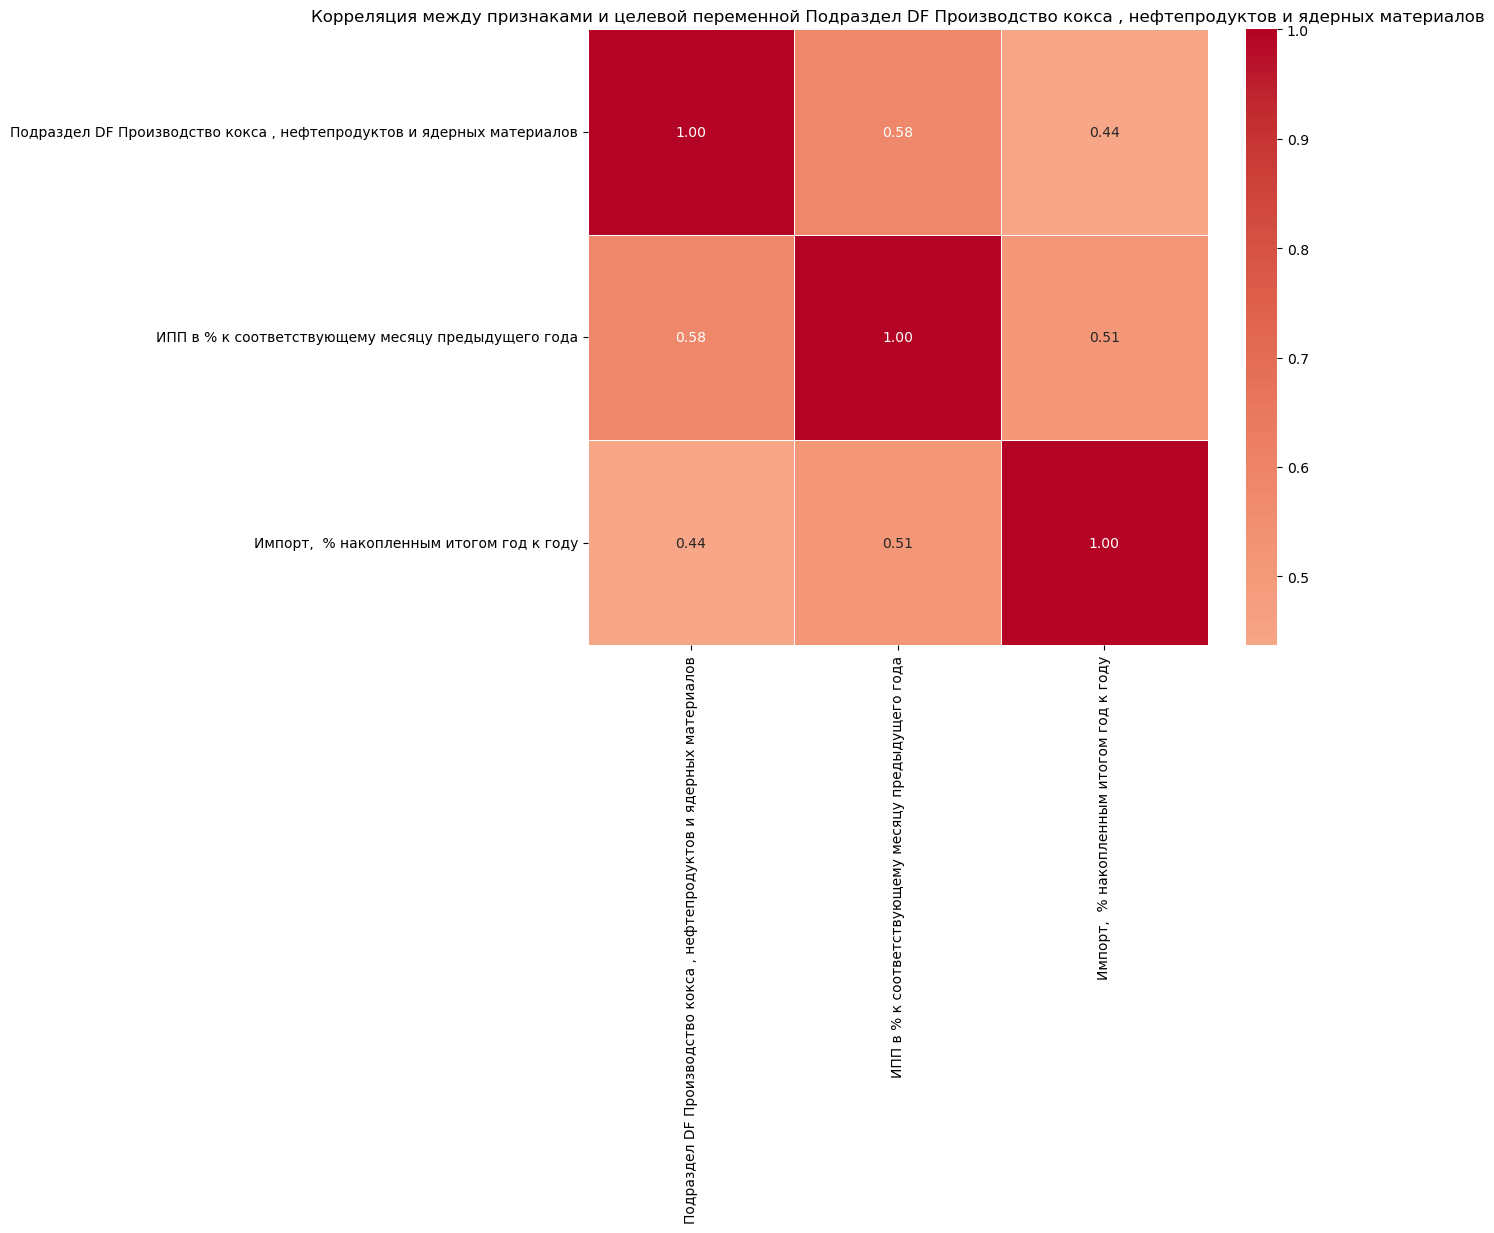


High correlations for Подраздел DH Производство резиновых и пластмассовых  изделий (after removing inter-correlated features):

ДИНАМИКА ОБОРОТА РОЗНИЧНОЙ ТОРГОВЛИ В % к соответствующему периоду предыдущего года                                                         0.649482
Импорт,  % накопленным итогом год к году                                                                                                    0.624110
Средневзвешенные процентные ставки по кредитам, предоставленным кредитными организациями нефинансовым организациям в рублях свыше 1 года    0.408556


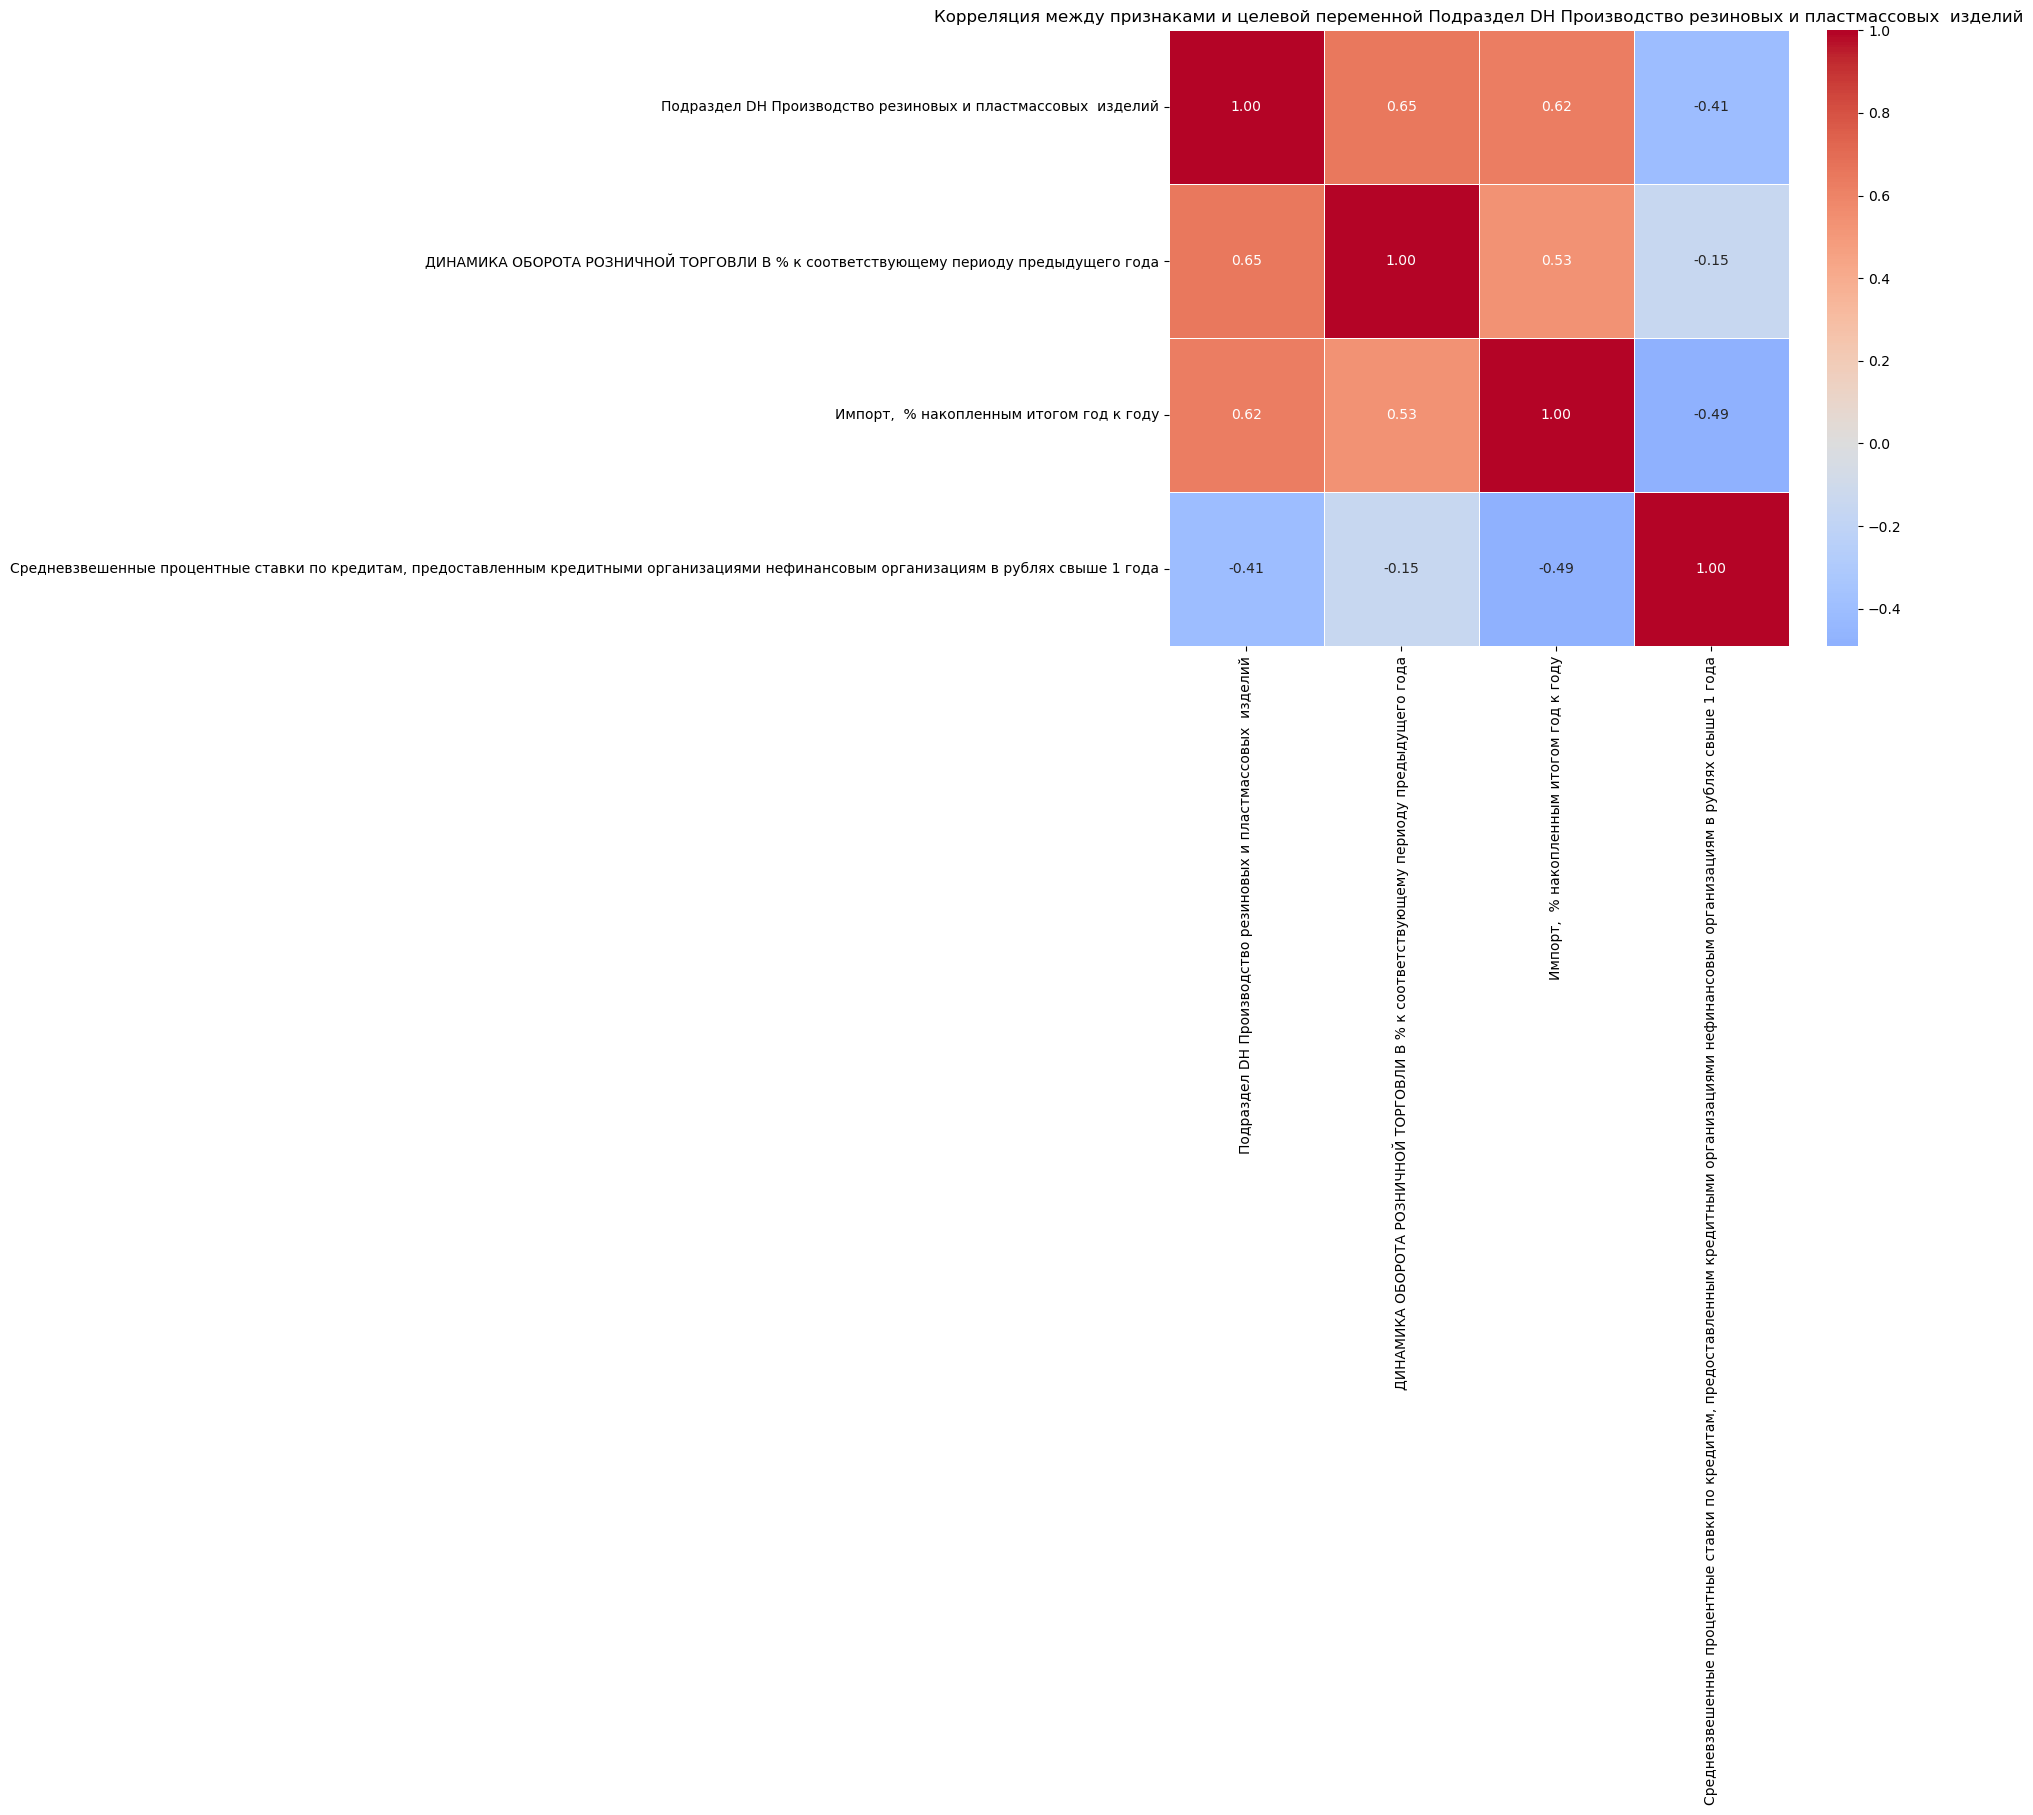


High correlations for Подраздел DG Химическое производство (after removing inter-correlated features):

ДИНАМИКА ОБОРОТА ОПТОВОЙ ТОРГОВЛИ в % к соответствующему периоду  предыдущего года    0.507604
Стоимость нефти                                                                       0.435594


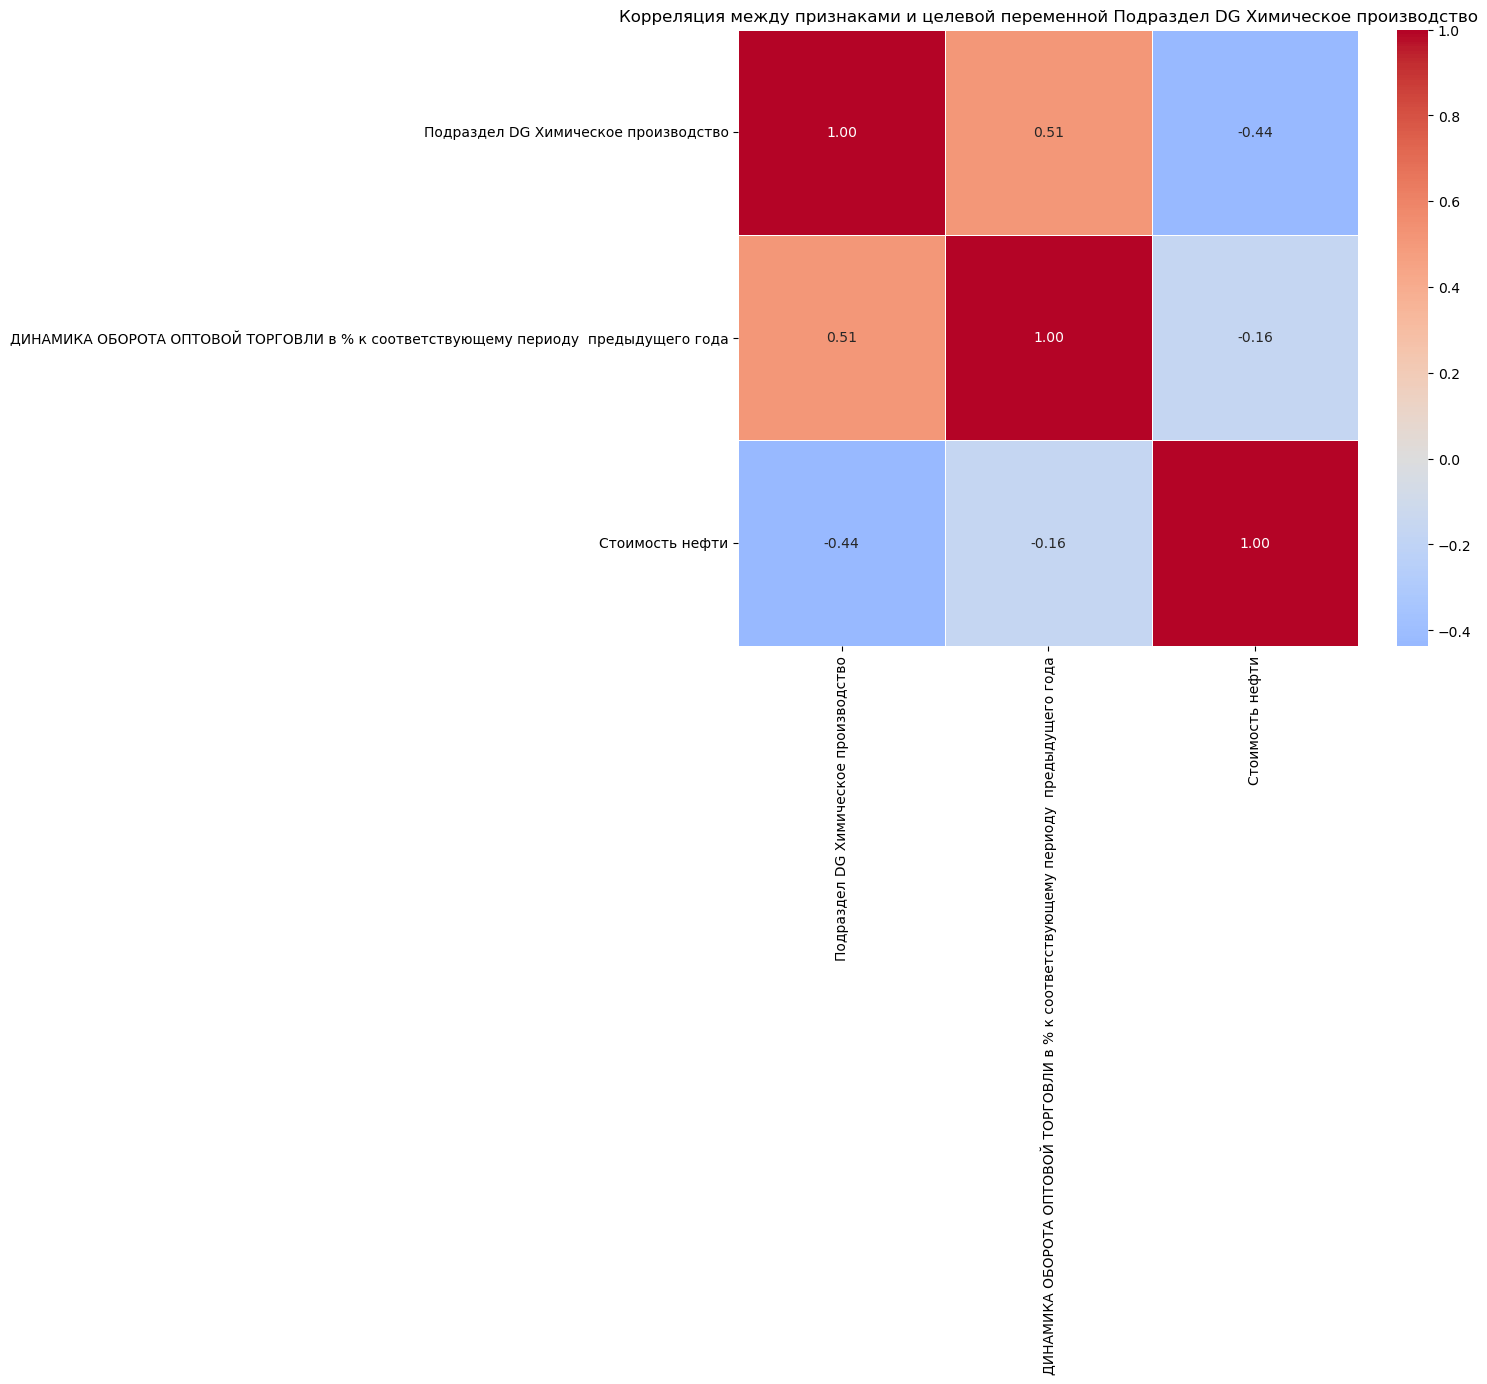

In [28]:
features_dict = {}
features_dict['Производство нефтепродуктов'] = get_high_corr_features(macro, 'Производство нефтепродуктов', 
                                                                      threshold=.4, multicoll=.6).columns.to_list()
features_dict['Производство резины'] = get_high_corr_features(macro, 'Производство резины', 
                                                              threshold=.4, multicoll=.6).columns.to_list()
features_dict['Химическое производство'] = get_high_corr_features(macro, 'Химическое производство', 
                                                                  threshold=.4, multicoll=.6).columns.to_list()

**надо следить, чтобы не было одних и тех же признаков, рассчитанных по-разному**

In [31]:
features_dict

{'Производство нефтепродуктов': ['ИПП в % к соответствующему месяцу предыдущего года',
  'Импорт,  % накопленным итогом год к году'],
 'Производство резины': ['ДИНАМИКА ОБОРОТА РОЗНИЧНОЙ ТОРГОВЛИ В % к соответствующему периоду предыдущего года',
  'Импорт,  % накопленным итогом год к году',
  'Средневзвешенные процентные ставки по кредитам, предоставленным кредитными организациями нефинансовым организациям в рублях свыше 1 года'],
 'Химическое производство': ['ДИНАМИКА ОБОРОТА ОПТОВОЙ ТОРГОВЛИ в % к соответствующему периоду  предыдущего года',
  'Стоимость нефти']}

# подготовка данных

In [30]:
def model_data(target: str or list, news_index=None, test_horizon=12, shift_features=0, union=False):
    ''' 
    На вход подается таргет (макро показатель) или список таргетов, 
    для него/них выбираются общие признаки, 
    по умолчанию новостной индекс не включается, его можно добавить

    На выход подается тренировочная и тестовая выборка признаков размера test_horizon для конкретного макро показателя/списка показателей

    target: str или list[str] - название таргета/список таргетов
    news_index: optional - новостной индекс
    
    Возвращает:
    macro_features: dataframe с общими признаками для всех переданных таргетов
    '''
    
    if isinstance(target, str):
        target_names = target_dict[target]
        macro_features = macro.loc[:, features_dict[target]]
        target_timerow = ipp.loc[:, target_names]
        
#     получается мы берем пересечение признаков. Должна быть еще опция объединения признаков.
    elif isinstance(target, list):
    # по умолчанию для нескольких таргетов берется пересечение, union=True дает объединение признаков
        if union==True:
            common_features = set(features_dict[target[0]])
            for t in target[1:]:
                common_features.update(features_dict[t])
        else:
            common_features = set(features_dict[target[0]])
            for t in target[1:]:
                common_features.intersection_update(features_dict[t])
            
        macro_features = macro.loc[:, list(common_features)]
        
        target_names = [target_dict[t] for t in target]
        target_timerow = ipp.loc[:, target_names]
    
    
    features_names = macro_features.columns.tolist()
            

    # объединяем таргет и фичи в одинг df, сдвигаем фичи относительно таргета. Должно быть удоюно инвертировать обрабтно 
    # и строить графики. Поэтому у таргета не должна меняться временная ось.
    # shift_features = 1 - сдвигаем вперед на 1 мес. фичи, то есть значением фичи месяц назад объясняем таргет текущего месяца
    # для нейросетей shift_features = 0, так как там другая логика использования лагов
    # ! но это дает нам возможноость строить только прогнозы на 1 шаг вперед. Для многошаговых прогнозов нужно
    # отдельно фичи прогнозировать.
    concat_data = pd.concat([target_timerow, macro_features.shift(shift_features)], axis=1)
    
    # к фичам добавили новостной индекс. Он без лага относительно таргета по умолчанию!
    if news_index is not None:
        concat_data = pd.concat([concat_data, news_index], axis=1)
        features_names.append(news_index.name)

    # Удалили NA в таблице. 
    concat_data.dropna(inplace=True)

    # Разделили на train и test
    train_target = concat_data[target_names].iloc[:-test_horizon]
    test_target = concat_data[target_names].iloc[-test_horizon:]
    train_features = concat_data[features_names].iloc[:-test_horizon, :]
    test_features = concat_data[features_names].iloc[-test_horizon:, :]
    
    return train_features, test_features, train_target, test_target
    # return concat_data

In [33]:
# в ячейке ниже спрятана prepare_features(dataset)

<!-- def prepare_features(dataset):
    #     нам нужны отдельно скалированные и не фактические данные
    #     raw_train, raw_test, train_target, test_target = model_data(target, news_index, forecast_horizon)
    train_features, test_features, train_target, test_target = dataset
    
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    scaler_X.fit(train_features)  # Только train!
    scaler_y.fit(pd.DataFrame(train_target))

#     scaled_train = scaler.fit_transform(raw_train)
    # Это неправильно. scaler должен знать распределение только тренировочных данных
#     scaled_test = scaler.fit_transform(raw_test)

    train_features_scaled = scaler_X.transform(train_features)
    test_features_scaled = scaler_X.transform(test_features)

    if isinstance(train_target, pd.Series):
        train_target_scaled = scaler_y.transform(pd.DataFrame(train_target))
        test_target_scaled = scaler_y.transform(pd.DataFrame(test_target))
    else:
        train_target_scaled = scaler_y.transform(train_target)
        test_target_scaled = scaler_y.transform(test_target)
        
    #     возвращаем индексы и названия
    train_features_scaled = pd.DataFrame(train_features_scaled, columns=train_features.columns, index=train_features.index)
    test_features_scaled = pd.DataFrame(test_features_scaled, columns=test_features.columns, index=test_features.index)

    if isinstance(train_target, pd.Series):

        train_target_scaled = pd.DataFrame(train_target_scaled.reshape(1,-1)[0],
                                           columns=[train_target.name], index=train_target.index)
        test_target_scaled = pd.DataFrame(test_target_scaled.reshape(1,-1)[0],
                                           columns=[test_target.name], index=test_target.index)
    else:
        
        train_target_scaled = pd.DataFrame(train_target_scaled, columns=train_target.columns, index=train_target.index)
        test_target_scaled = pd.DataFrame(test_target_scaled, columns=test_target.columns, index=test_target.index)
        
    
    
    set_data = train_features_scaled, test_features_scaled, train_target_scaled, test_target_scaled
    return scaler_y, set_data
 -->

<!-- my_scaler, set_data = prepare_features(test_df) -->

<!-- - если для модели нужны данные в абсолюных величинах, используется **model_data()**

- если нужны нормализованные данные, то используется **prepare_features()**

обе функции на выходе дают тренировочные и тестовые выборки признаков и таргета/таргетов -->

# VAR

Нужно использовать varx и прогнозировать на 3 мес. вперед. Только так есть смысл с нейросетями сравнивать.
при этом на прогнозном горизонте нужно переиспользоваьт прогнозы var для таргетов и замораживать последние известные значения для фичей или отдельно их прогнозировать

## VARX

In [35]:
def select_best_lag(endog, exog, max_lag=5, criterion='aic'):
    """
    Подбирает оптимальный лаг для VARX (VARMAX) по критерию AIC или BIC.
    endog: DataFrame — таргеты
    exog: DataFrame — экзогенные переменные
    max_lag: int — максимальный перебираемый лаг
    criterion: 'aic' или 'bic'
    """
    best_score = np.inf
    best_lag = None
    scores = {}
    for lag in range(1, max_lag + 1):
        try:
            model = VARMAX(endog, exog=exog, order=(lag, 0))
            res = model.fit(disp=False)
            score = getattr(res, criterion)
            scores[lag] = score
            if score < best_score:
                best_score = score
                best_lag = lag
        except Exception as e:
            print(f"Lag {lag}: error {e}")
            continue
    return best_lag, scores

In [37]:
def rolling_varx_forecast(
    train_target, train_features, test_target, test_features, lags=2, horizon=3):
    """
    Скользящий прогноз VARX/VARMAX: rolling window с прогнозом на 3 шага вперед.
    На каждом окне экзогенные берутся как последнее доступное значение в расширенной истории.
    train_target, train_features, test_target, test_features — DataFrame!
    Возвращает:
      - forecasts: (n_windows, horizon, n_targets)
      - actuals:   (n_windows, horizon, n_targets)
      - insample_forecasts: список, каждый элемент — DataFrame in-sample прогноза на расширенном обучающем окне
      - insample_actuals: список, каждый элемент — DataFrame фактических значений на обучающем окне
    """
    forecasts = []
    actuals = []
    insample_forecasts = []
    insample_actuals = []

    n_test = test_target.shape[0]

    # Копии для чистоты
    endog = train_target.copy()
    exog = train_features.copy()
    test_endog = test_target.copy()
    test_exog = test_features.copy()

    
    for start in range(n_test - horizon + 1):
        # Расширенная история на этом окне
        hist_endog = pd.concat([endog, test_endog.iloc[:start]], axis=0, ignore_index=True)
        hist_exog = pd.concat([exog, test_exog.iloc[:start]], axis=0, ignore_index=True)

        # Экзогенные на 3 будущих шага — последнее известное
        last_exog = hist_exog.iloc[-1]
        exog_future = pd.DataFrame([last_exog.values]*horizon, columns=hist_exog.columns)

        try:
            # Переобучаем модель через каждые три шага, то есть перед каждым очередным тройным прогнозом 
            # строится новая модель на расширенной истории (train + всё, что уже известно из test до текущего окна)
            model = VARMAX(hist_endog, exog=hist_exog, order=(lags, 0))#2-й параметр в order - это MA (внезапно)
            res = model.fit(disp=False)

            # Прогноз на 3 шага вперёд
            fcst = res.forecast(steps=horizon, exog=exog_future)
            forecasts.append(fcst.values)
            actuals.append(test_endog.iloc[start:start+horizon].values)

            # In-sample прогноз (только на обучающем окне)
            insample_pred = res.fittedvalues  # shape: (len(hist_endog), n_targets)
            insample_forecasts.append(insample_pred.values)
            insample_actuals.append(hist_endog.values)
        except Exception as e:
            print(f"Ошибка на окне {start}: {e}")
            continue

    forecasts = np.array(forecasts)
    actuals = np.array(actuals)


    return forecasts, actuals, insample_forecasts, insample_actuals

In [39]:
def forecasts_to_long_df(forecasts, actuals, test_target, horizon=3):
    """
    forecasts: (n_windows, horizon, n_targets)
    actuals:   (n_windows, horizon, n_targets)
    test_target: DataFrame, shape (n_test, n_targets), индекс — даты
    
    Вернет DataFrame: columns = [iteration, forecast_date, y_hat, y_true]
    """
    n_windows, h, n_targets = forecasts.shape
    result = []

    # Получаем даты для rolling окон
    test_dates = test_target.index

    for i in range(n_windows):
        for j in range(horizon):
            for k in range(n_targets):
                # Вычисляем индекс даты
                date_idx = i + j
                if date_idx >= len(test_dates):
                    continue  # на случай выхода за тестовый диапазон
                result.append({
                    'iteration': i,
                    'forecast_date': test_dates[date_idx],
                    'target': test_target.columns[k],
                    'y_hat': forecasts[i, j, k],
                    'y_true': actuals[i, j, k]
                })

    df_long = pd.DataFrame(result)
    return df_long


In [41]:
def insample_to_long_df(insample_forecasts, insample_actuals, train_target, test_target):
    """
    insample_forecasts, insample_actuals: списки массивов (len=n_windows), shape каждого: (len_hist, n_targets)
    train_target: DataFrame (train_len, n_targets), индекс — даты
    test_target: DataFrame (n_test, n_targets), индекс — даты

    Вернет DataFrame: columns = [iteration, forecast_date, target, y_hat, y_true]
    """
    result = []
    train_dates = train_target.index
    test_dates = test_target.index
    n_windows = len(insample_forecasts)
    n_train = train_target.shape[0]
    n_targets = train_target.shape[1]

    for i in range(n_windows):
        n_hist = insample_forecasts[i].shape[0]
        # Даты для этого окна: сначала train, затем часть test
        dates = list(train_dates) + list(test_dates[:max(0, n_hist - n_train)])
        for t in range(n_hist):
            for k in range(n_targets):
                result.append({
                    'iteration': i,
                    'forecast_date': dates[t],
                    'target': train_target.columns[k],
                    'y_hat': insample_forecasts[i][t, k],
                    'y_true': insample_actuals[i][t, k]
                })
    df_long = pd.DataFrame(result)
    return df_long

In [43]:
test_df = model_data(['Производство резины', 
                      'Химическое производство', 
                      'Производство нефтепродуктов'], 
                       shift_features=1, news_index=llama, union=True)

In [45]:
train_features, test_features, train_target, test_target = test_df
best_lag, scores = select_best_lag(train_target, train_features,
                                   max_lag=5, criterion='aic')

forecasts, actuals, insample_forecasts, insample_actuals = rolling_varx_forecast(train_target,
                            train_features, test_target, test_features, lags=best_lag, horizon=3)

insample_var = insample_to_long_df(insample_forecasts, insample_actuals, train_target, test_target)
insample_var['target'] = insample_var.target.replace(inverse_d)

outsample_var = forecasts_to_long_df(forecasts, actuals, test_target, horizon=3)
outsample_var['target'] = outsample_var.target.replace(inverse_d)

**отрисовка insample/outsample**

**название надо менять вручную**


In [46]:
def plot_samples(insample, outsample, model_name):
    
    for check_target in insample['target'].unique():
        insample_0 = insample[(insample['target']==check_target)&(insample['iteration']==9)]
        
        mape_train = (mean_absolute_percentage_error(insample_0.y_true, insample_0.y_hat)*100).round(2)
        
        insample_0 = insample_0[insample_0.forecast_date >= '2019-01-31']
        
        plt.figure(figsize=(12,6))
        plt.plot(insample_0.forecast_date, insample_0.y_true, label='Фактические значения', color='black', alpha=0.6)
        plt.plot(insample_0.forecast_date, insample_0.y_hat, label='Внутривыборочный прогноз', color='green', alpha=0.6)

        cv_all = outsample[outsample['target'] == check_target]
    
        # mape считаю по всем наблюдениям кросс-валидации
        mape_test = (mean_absolute_percentage_error(cv_all['y_true'], cv_all['y_hat'])*100).round(2)
        
        cv_iter = cv_all[cv_all.iteration % 3 == 0]
        unique_iter = cv_iter.iteration.unique()
        colors = plt.cm.get_cmap('tab10', len(unique_iter))
        
        for i, iter in enumerate(unique_iter):
            
            cv_iter_plot = cv_iter[cv_iter['iteration'] == iter]
            plt.plot(cv_iter_plot['forecast_date'], cv_iter_plot['y_hat'], '-o',
                     color=colors(i), alpha=0.9, lw=3, label=f'Вневыборочный прогноз {i}') 
                    
        plt.legend(ncol=2, fontsize=9)
        plt.grid(True)
        plt.title(check_target + '\n\nС новостным индексом LLaMA' + '\n'+ f'MAPE на тренировочной выборке {mape_train}%' +'\n'+ f'MAPE на тестовой выборке {mape_test}%')

        # filename = f'for_6-05-2025/index/other/{model_name}-llama-{check_target}.png'
        # plt.savefig(filename, bbox_inches='tight', dpi=300)

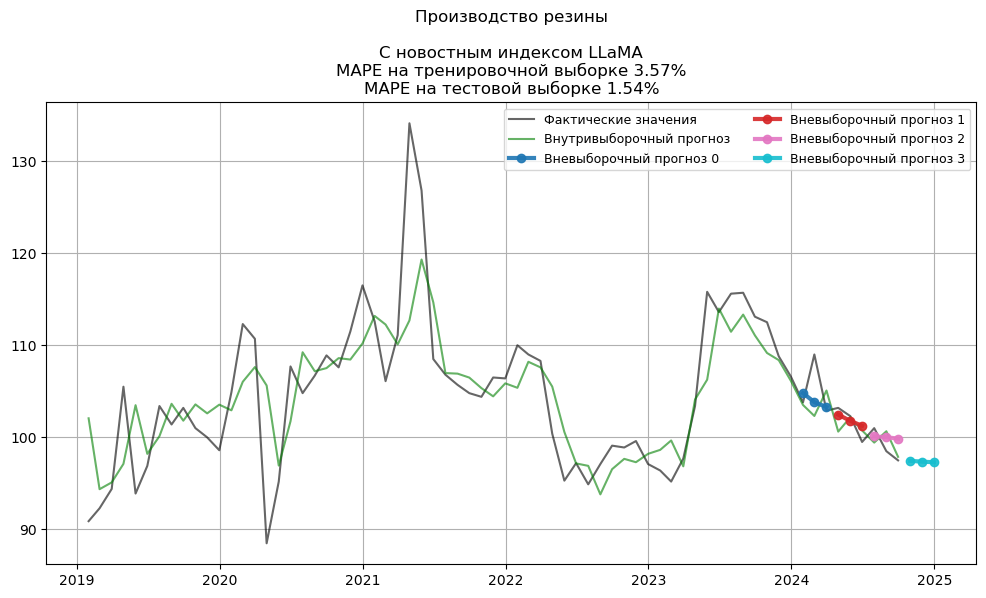

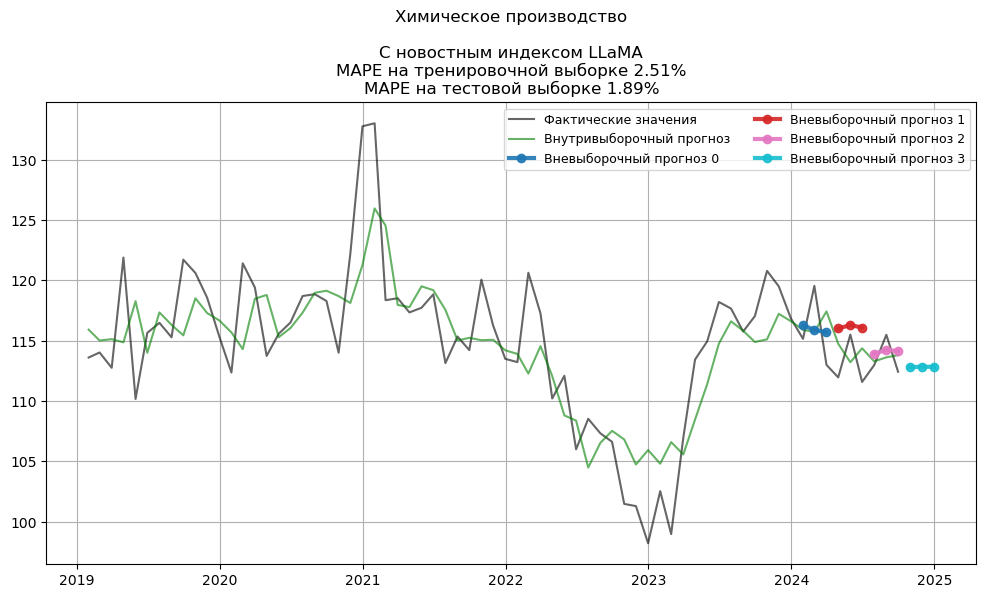

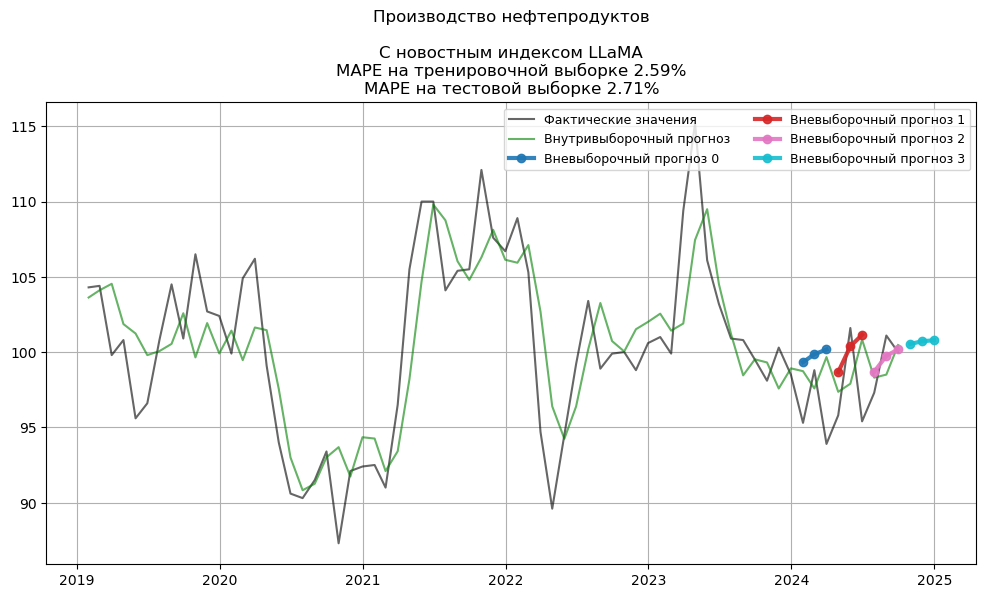

In [47]:
plot_samples(insample_var, outsample_var, 'var')

<!-- **графики на $shift\_features=3$**

метрики на трейне и тесте кажутся адекватными -->

# ARIMA

In [51]:
def arima_seas(ts, pdq, exogen=None):
    results = []
    
    for param in pdq:
        try:
            if exogen is not None:
                mod = ARIMA(ts, exog=exogen, order=param)
            else:
                mod = ARIMA(ts, order=param)  
                
            res = mod.fit()
            results.append((res.bic, param))
        except Exception as e:
            print(e)
            continue
  
    results.sort(key=lambda x: x[0])
    return results[0] if results else None

<!-- **какая проблема**:

если во временном ряде есть пропущенные даты, то в предсказаниях (и на графиках соответственно) вместо даты предсказанного значения будет порядковый номер (т.е. следующий после тренировочных данных), поэтому нужно либо следить за этим моментом, либо на моменте предсказания присваивать некоторую дату вручную (можно как-то основываться на датах из экзогенных переменных)) -->

**что происходит**:

данные деляться на тренировочную и тестовую таким образом, чтобы можно было провести кросс-валидацию на $windows$ фолдах с размером тестовой выборки $forecast\_horizon$

с каждым новым $windows$ тестовая выборка смещается на 1 наблюдение вперед, модель обучается на трейне, делает предикт на тесте

<!-- без переобучения не получается, т.к. модели придется делать предикты, "перепрыгивая" через наблюдения, оставшиеся между тренировочной выборкой и тестовой (при условии, что тестовую выборку хотим двигать и делать предикты по $forecast\_horizon$ штук на разных временных промежутках) -->

In [55]:
def arima_cross_validation(target: str, exog=True, news_index=None, forecast_horizon=3, windows=10, shift_features=0, union=False):

    '''
    forecast_horizon - сколько предсказаний в тестовой выборке (на кросс-валидации)
    shift_features - по какому моменту t-shift_features экзогенной переменной делается прогноз в момент t зависимой переменной
    '''
    
    p, d, q = range(0,4), [0,1], range(0,4)
    pdq = list(itertools.product(p, d, q))
    
    train_features, test_features, train_target, test_target = model_data(
                                                                          ['Производство резины', 
                                                                           'Химическое производство', 
                                                                           'Производство нефтепродуктов'],
                                                                          news_index, 
                                                                          forecast_horizon, 
                                                                          shift_features=shift_features,
                                                                          union=union  
                                                                         )
    train_target = train_target[target_dict[target]]
    test_target = test_target[target_dict[target]]
        
    if exog:
        all_features = pd.concat([train_features, test_features])
    all_target = pd.concat([train_target, test_target])

    total_length = len(all_target)
    window_size = total_length - windows - forecast_horizon + 1    #   for test size=12
    
    predictions = []
    true_values = []
    insample_forecasts = []
    insample_actuals = []
    
    
    for i in range(windows):
        train_end = window_size + i
        test_start = train_end
        test_end = test_start + forecast_horizon
        
        if test_end > total_length:
            break
            
        train_target_window = all_target.iloc[:train_end]
        test_target_window = all_target.iloc[test_start:test_end]
        
        if exog:
            train_features_window = all_features.iloc[:train_end]
            test_features_window = all_features.iloc[test_start:test_end]
            
            best_model = arima_seas(train_target_window, exogen=train_features_window, pdq=pdq)
            model = ARIMA(train_target_window, exog=train_features_window, order=best_model[1])
            model_fit = model.fit()

            prediction = model_fit.predict(
                start=len(train_target_window),
                end=len(train_target_window) + forecast_horizon - 1,
                exog=test_features_window

            )
            prediction.index = test_target_window.index

            insample_pred = model_fit.fittedvalues
            insample_pred = np.array(insample_pred).reshape(-1,1)

        
        predictions.append(prediction)
        true_values.append(test_target_window)
        insample_forecasts.append(insample_pred)
        insample_actuals.append(np.array(train_target_window).reshape(-1,1))
    
    return {
        'predictions': predictions,
        'true_values': true_values,
        'in_sample_forecast': insample_forecasts,
        'in_sample_true': insample_actuals,
    }

In [57]:
def arima_samples(target: str, union, news_index): # fixed parameters
    result = arima_cross_validation(target, exog=True, news_index=news_index, forecast_horizon=3, shift_features=1, union=union)
    
    outsample = forecasts_to_long_df(np.array(result['predictions']).reshape(10, 3, 1), 
                         np.array(result['true_values']).reshape(10, 3, 1), 
                         pd.DataFrame(pd.concat(result['true_values']).drop_duplicates())
                        )
    outsample['target'] = outsample.target.replace(inverse_d)
    
    test_df = model_data(['Производство резины', 
                          'Химическое производство', 
                          'Производство нефтепродуктов'], 
                         shift_features=1, union=union)
    
    train_target = test_df[2][target_dict[target]]
    test_target = test_df[3][target_dict[target]]
    
    insample = insample_to_long_df(result['in_sample_forecast'], 
                        result['in_sample_true'], 
                        pd.DataFrame(train_target),
                        pd.DataFrame(test_target)
                        )
    insample['target'] = insample.target.replace(inverse_d)
    return insample, outsample

In [59]:
arima_insample_cox, arima_outsample_cox = arima_samples('Производство нефтепродуктов', union=True, news_index=llama)
arima_insample_rez, arima_outsample_rez = arima_samples('Производство резины', union=True, news_index=llama)
arima_insample_chem, arima_outsample_chem = arima_samples('Химическое производство', union=True, news_index=llama)

In [60]:
insample_arima = pd.concat([arima_insample_cox, arima_insample_rez, arima_insample_chem])
outsample_arima = pd.concat([arima_outsample_cox, arima_outsample_rez, arima_outsample_chem])

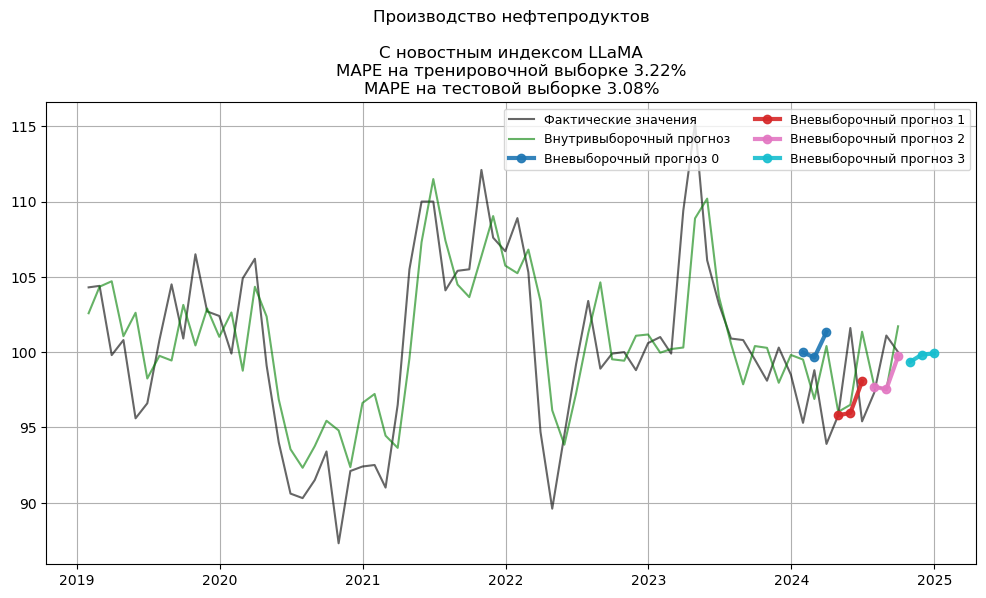

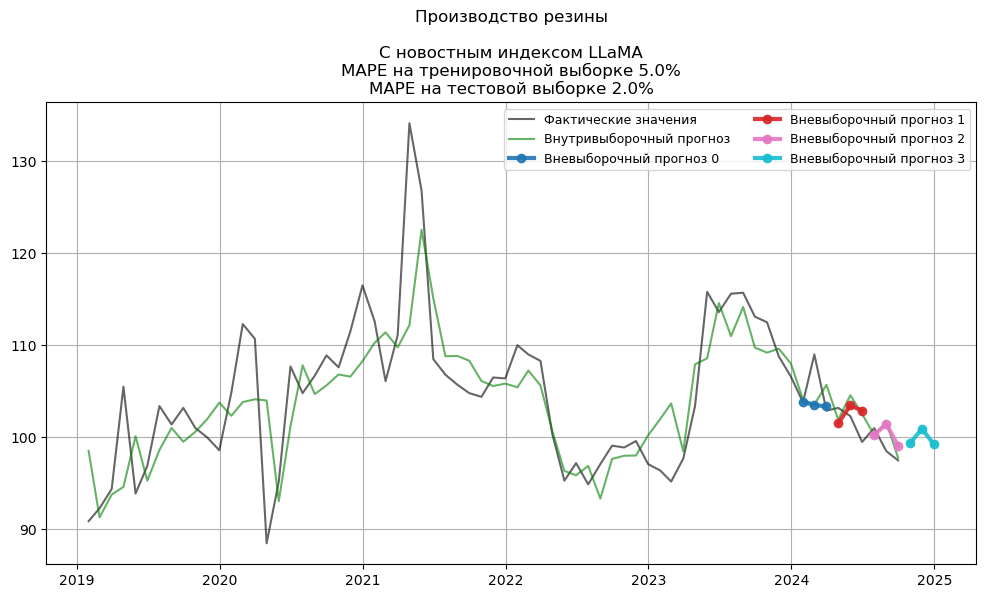

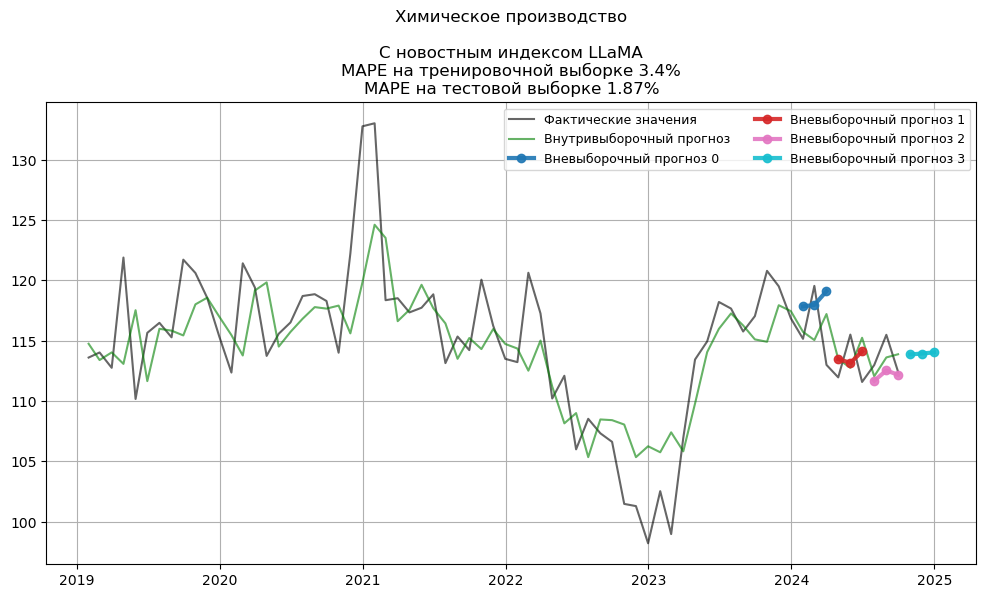

In [61]:
plot_samples(insample_arima, outsample_arima, 'arima')

# DM-test

<!-- def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
            is_actual_ok = compiled_regex(str(abs(actual)))
            is_pred1_ok = compiled_regex(str(abs(pred1)))
            is_pred2_ok = compiled_regex(str(abs(pred2)))
            if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):
                msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
                rt = -1
                return (rt,msg)
        return (rt,msg)

    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np

    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []

    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()

    # Length of lists (as real numbers)
    T = float(len(actual_lst))

    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)

    # Mean of d
    mean_d = pd.Series(d_lst).mean()

    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)

    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')

    rt = dm_return(DM = DM_stat, p_value = p_value)

    return rt -->

<!-- outsample_var.rename(columns = {'y_hat': 'y_hat_var'}, inplace=True)
outsample_arima.rename(columns = {'y_hat': 'y_hat_arima'}, inplace=True) -->

<!-- outsamples = outsample_var.merge(outsample_arima, on=['iteration', 'forecast_date', 'target', 'y_true']) -->

**сравнение моделей через DM-тест**

<!-- def compare_models(model_1: str, model_2: str, samples_info):
    print(f'Сравнение моделей {model_1} и {model_2}\n')
    for check_target in samples_info.target.unique():
        sample_target = samples_info[samples_info.target == check_target]
        dm_result = dm_test(sample_target.y_true, 
                            sample_target[f'y_hat_{model_1}'], 
                            sample_target[f'y_hat_{model_2}'])
        
        dm_stat = round(dm_result[0], 3)
        dm_pval = round(dm_result[1], 3)
        print(f'Модель для {check_target}:')
        if (dm_stat < 0) & (dm_pval < 0.1):
            print(f' {model_1} значимо лучше:\n Статистика теста: {dm_stat}\n P-value: {dm_pval}\n')
        elif (dm_stat < 0) & (dm_pval > 0.1):
            print(f' {model_1} НЕзначимо лучше:\n Статистика теста: {dm_stat}\n P-value: {dm_pval}\n')
        elif (dm_stat > 0) & (dm_pval < 0.1):
            print(f' {model_2} значимо лучше:\n Статистика теста: {dm_stat}\n P-value: {dm_pval}\n')
        else:
            print(f' {model_2} НЕзначимо лучше:\n Статистика теста: {dm_stat}\n P-value: {dm_pval}\n')     -->

<!-- compare_models('var', 'arima', outsamples) -->

# N-BEATS / N-BEATSx / N-HITS

In [65]:
# Можно подавать в NeuralForecast
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS

import neuralforecast
print(neuralforecast.__version__)

import pytorch_lightning
print(pytorch_lightning.__version__)

3.0.0
2.5.1


## N-HITS для нескольких таргетов

In [67]:
nhits_df = model_data(['Производство резины', 
                       'Химическое производство', 
                       'Производство нефтепродуктов'], shift_features=0, news_index=llama, union=True)
train_features, test_features, train_target, test_target = nhits_df

In [69]:
def prepare_nf_long_format(train_features, test_features, train_target, test_target):
    # Склеиваем train и test отдельно по features и target
    features_all = pd.concat([train_features, test_features])
    targets_all = pd.concat([train_target, test_target])

    # Проверяем что индексы совпадают (дата)
    assert (features_all.index == targets_all.index).all(), "Индексы (дата) должны совпадать"
    
    # Результирующие списки
    dfs = []
    for target_name in targets_all.columns:
        # Формируем DataFrame для одного таргета
        df = pd.DataFrame({
            'unique_id': target_name,
            'ds': targets_all.index,
            'y': targets_all[target_name].values
        })
        # Добавляем фичи
        for col in features_all.columns:
            df[col] = features_all[col].values
        dfs.append(df)
    
    # Склеиваем в один DataFrame
    result = pd.concat(dfs, ignore_index=True)
    return result


In [71]:
def cv_nhits(long_dataframe, input_size=12, horizon=3, n_windows=10, local_scaler_type=None):
    
    num_targets = long_dataframe.unique_id.nunique()
    long_dataframe = long_dataframe.sort_values(['ds', 'unique_id'])    
    end_of_train = len(long_dataframe) - input_size * num_targets
    step_size = num_targets
    
    exog_list = long_dataframe.drop(columns=['unique_id', 'ds', 'y']).columns.tolist()
    
    cv_outsample = []
    for window_idx in range(n_windows):
        train_end = end_of_train + window_idx * step_size
        test_end = train_end + horizon * num_targets
        
        train_df = long_dataframe[:train_end]
        test_df = long_dataframe[train_end:test_end]
    
        model = NHITS(input_size=input_size, 
                      h=horizon,
                      hist_exog_list=exog_list,
                     )
        nf = NeuralForecast(models=[model], freq='M', local_scaler_type=local_scaler_type)
        nf.fit(train_df, 
              )
        
        outsample_forecast = nf.predict(futr_df=test_df)
        outsample_forecast = outsample_forecast.merge(test_df[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'])
        outsample_forecast['iteration'] = window_idx

        cv_outsample.append(outsample_forecast)
        
    insample_forecast = nf.predict_insample()
    insample_forecast['iteration'] = window_idx
    
    return nf, cv_outsample, insample_forecast

**названия надо менять вручную**

In [73]:
def plot_nhits(outsample_forecast, insample_forecast, model_name):
    
    last_insample = insample_forecast.drop(columns=['cutoff']).drop_duplicates(subset=['unique_id', 'ds', 'y'], keep='last')
    
    for unique_id in insample_forecast['unique_id'].unique():
        data = last_insample[last_insample['unique_id'] == unique_id] # внутривыборочный
        mape_train = (mean_absolute_percentage_error(data['y'], data['NHITS'])*100).round(2)

        data = data[data.ds >= '2019-01-31']
        plt.figure(figsize=(12,6))
        plt.plot(data.ds, data.y, label='Фактические значения', color='black', alpha=0.6)
        plt.plot(data.ds, data.NHITS, label='Внутривыборочный прогноз', color='green', alpha=0.6)


        cv = pd.concat(outsample_forecast)
        cv = cv[cv['unique_id'] == unique_id]
        mape_test = (mean_absolute_percentage_error(cv['y'], cv['NHITS'])*100).round(2)

        cv_iter = cv[cv.iteration % 3 == 0]
        unique_iter = cv_iter.iteration.unique()
        colors = plt.cm.get_cmap('tab10', len(unique_iter))


        for i, iter in enumerate(unique_iter):
            
            cv_iter_plot = cv_iter[cv_iter['iteration'] == iter]
            plt.plot(cv_iter_plot['ds'], cv_iter_plot['NHITS'], '-o',
                     color=colors(i), alpha=0.9, lw=3, label=f'Вневыборочный прогноз {i}') 
                    
        plt.legend(ncol=2, fontsize=9)
        plt.grid(True)
        plt.title(unique_id + '\n\nС новостным индексом LLaMA' + '\n'+ f'MAPE на тренировочной выборке {mape_train}%' +'\n'+ f'MAPE на тестовой выборке {mape_test}%')
        
        # filename = f'for_6-05-2025/index/other/{model_name}-llama-{unique_id}.png'
        # plt.savefig(filename, bbox_inches='tight', dpi=300)

In [75]:
long_df = prepare_nf_long_format(train_features, test_features, train_target, test_target)
long_df.unique_id = long_df.unique_id.replace(inverse_d)

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

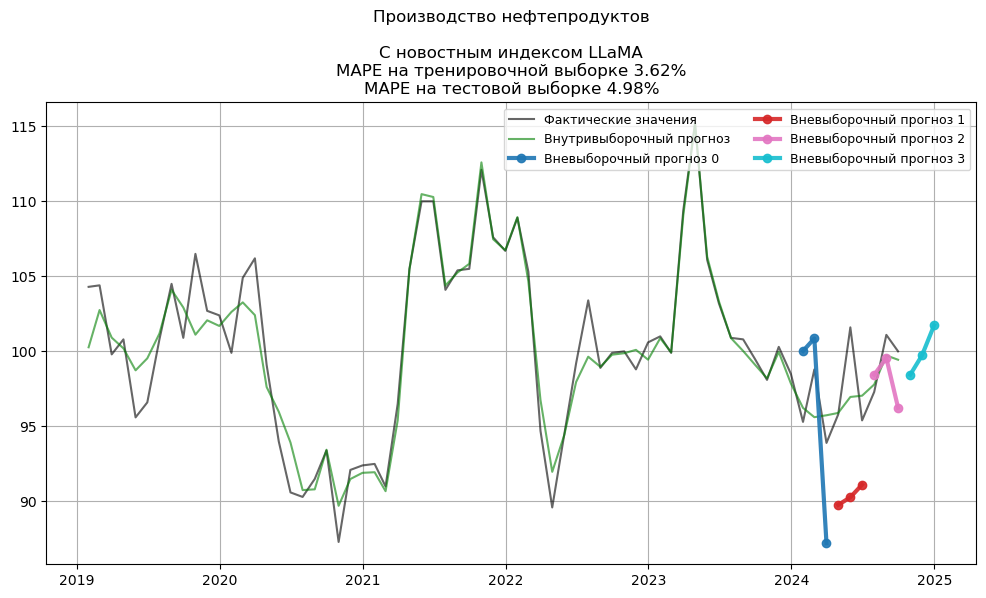

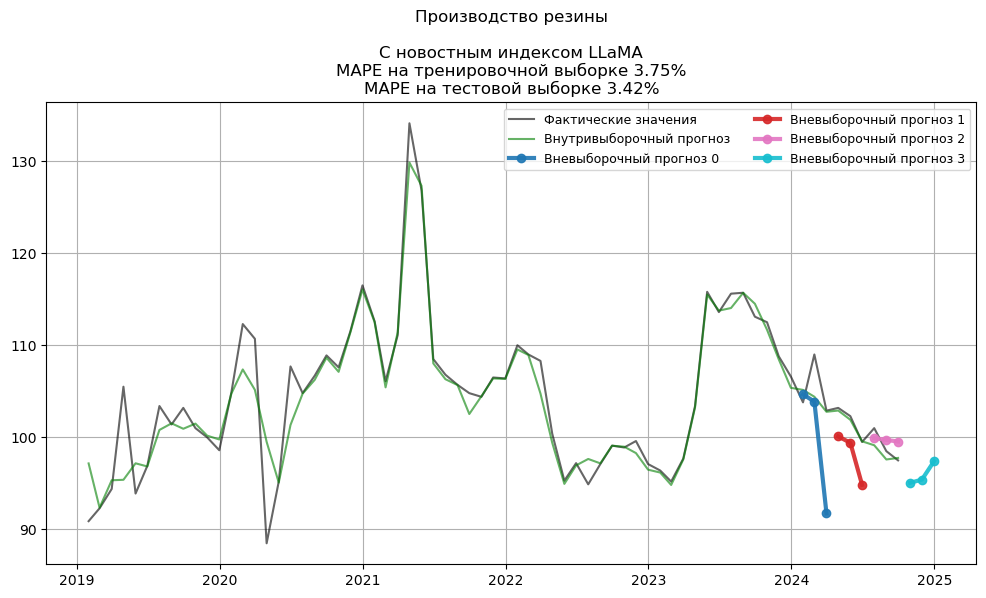

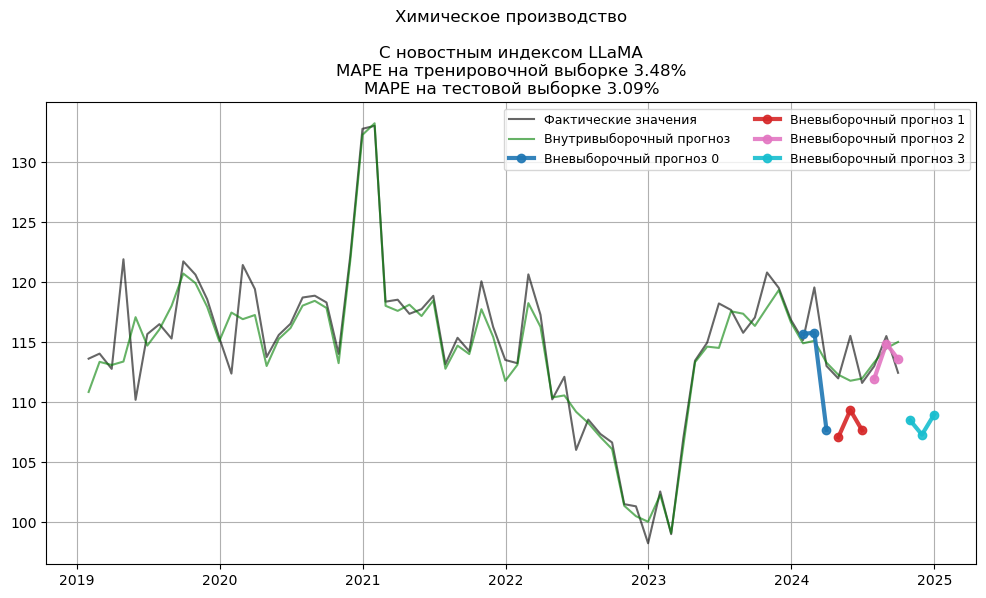

In [77]:
model_nf, outsample_all, insample_all = cv_nhits(long_df)
plot_nhits(outsample_all, insample_all, 'nhits')

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

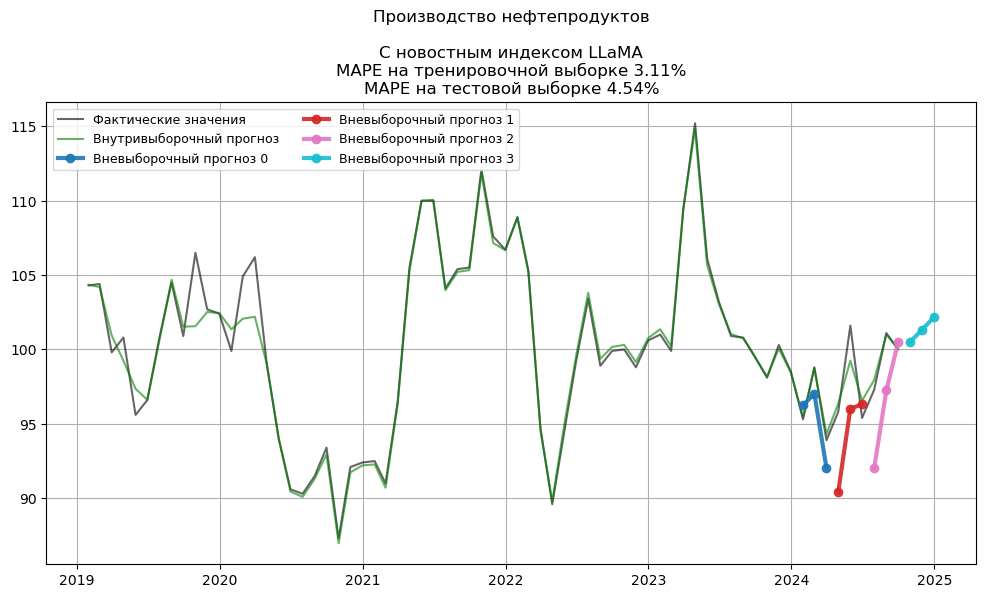

In [79]:
cox_long = long_df[long_df['unique_id'] == 'Производство нефтепродуктов']
model_nf_cox, outsamp_cox, insamp_cox = cv_nhits(cox_long)
plot_nhits(outsamp_cox, insamp_cox, 'nhits-1')

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

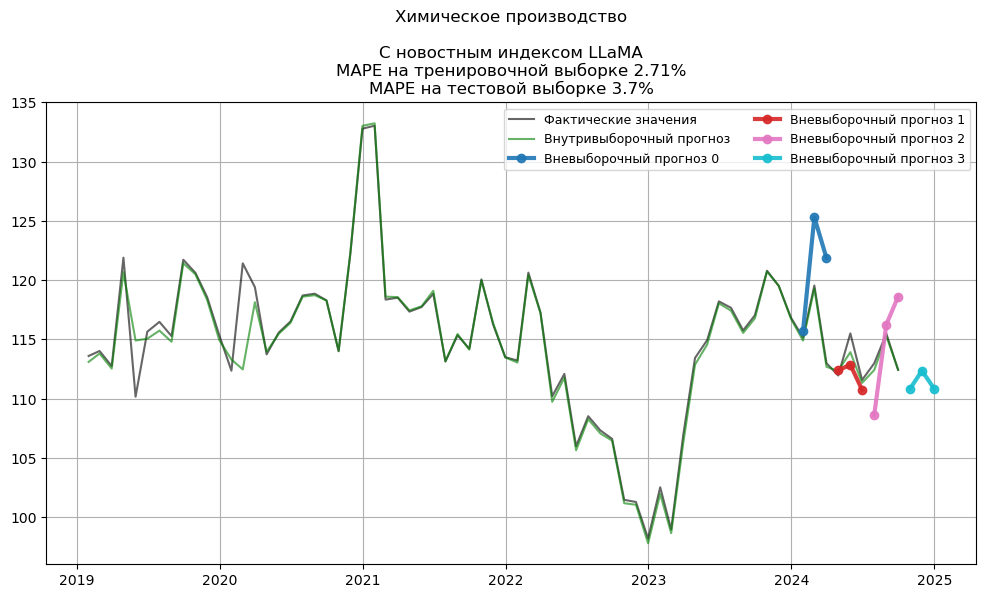

In [80]:
chem_long = long_df[long_df['unique_id'] == 'Химическое производство']
model_nf_chem, outsamp_chem, insamp_chem = cv_nhits(chem_long)
plot_nhits(outsamp_chem, insamp_chem, 'nhits-1')

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.939     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

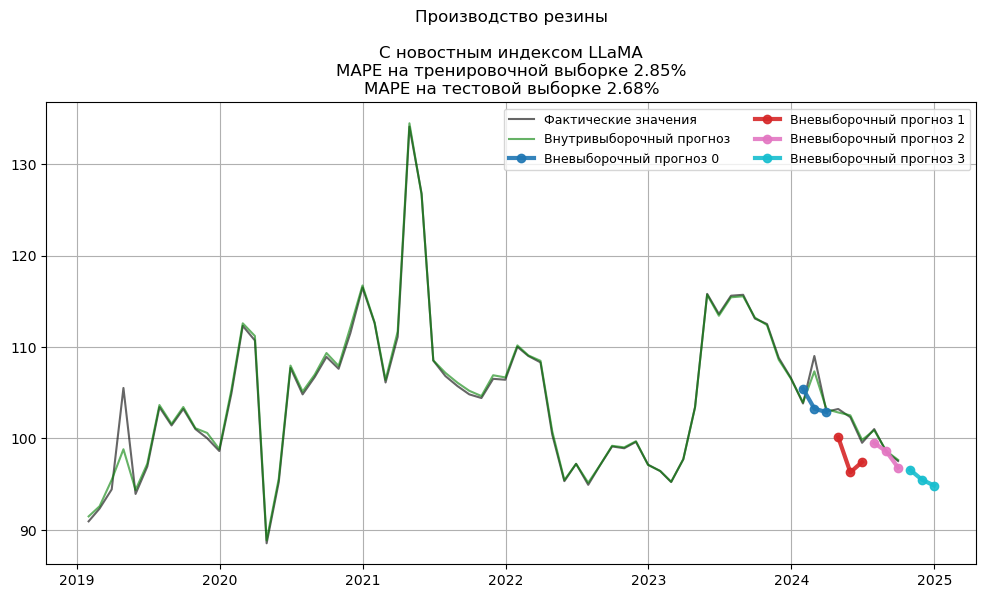

In [81]:
rez_long = long_df[long_df['unique_id'] == 'Производство резины']
model_nf_rez, outsamp_rez, insamp_rez = cv_nhits(rez_long)
plot_nhits(outsamp_rez, insamp_rez, 'nhits-1')

# Статистики

In [85]:
def directional_accuracy(actual, predicted):
    actual_change = np.sign(np.diff(actual))
    predicted_change = np.sign(np.diff(predicted))
    correct = actual_change == predicted_change
    return np.mean(correct)

In [87]:
outsample_nhits = pd.concat(outsample_all)
outsample_nhits.rename(columns={
    'unique_id': 'target',
    'ds': 'forecast_date',
    'y': 'y_true',
}, inplace=True)

stats_3 = outsample_var.merge(outsample_nhits, on=['iteration', 'forecast_date', 'target', 'y_true'])
stats_3.rename(columns={
    'NHITS': 'NHITS-3',
    'y_hat': 'VAR'
}, inplace=True)

In [89]:
outsamp_cox_df = pd.concat(outsamp_cox)
outsamp_rez_df = pd.concat(outsamp_rez)
outsamp_chem_df = pd.concat(outsamp_chem)

stats_single = pd.concat([outsamp_cox_df, outsamp_rez_df, outsamp_chem_df], axis=0)
stats_single.rename(columns={
    'unique_id': 'target',
    'ds': 'forecast_date',
    'y': 'y_true'   
}, inplace=True)

stats_1 = stats_single.merge(outsample_arima, on=['iteration', 'forecast_date', 'target', 'y_true'])
stats_1.rename(columns={
    'NHITS': 'NHITS-1',
    'y_hat': 'ARIMA'
}, inplace=True)

In [91]:
concated = stats_1.merge(stats_3, on=['iteration', 'forecast_date', 'target', 'y_true'])

In [95]:
concated.to_csv('for_6-05-2025/index/other/predictions_union_llama.csv', index=None)

In [97]:
mape_all = concated.groupby('target').apply(
    lambda x: pd.Series({
        'NHITS-1': mean_absolute_percentage_error(x['y_true'], x['NHITS-1']),
        'ARIMA': mean_absolute_percentage_error(x['y_true'], x['ARIMA']),
        'NHITS-3': mean_absolute_percentage_error(x['y_true'], x['NHITS-3']),
        'VAR': mean_absolute_percentage_error(x['y_true'], x['VAR'])
    })
)

da_all = concated.groupby('target').apply(
    lambda x: pd.Series({
        'NHITS-1': directional_accuracy(x['y_true'], x['NHITS-1']),
        'ARIMA': directional_accuracy(x['y_true'], x['ARIMA']),
        'NHITS-3': directional_accuracy(x['y_true'], x['NHITS-3']),
        'VAR': directional_accuracy(x['y_true'], x['VAR'])
    })
)

mape_all = round(mape_all * 100, 2)
da_all = round(da_all * 100, 2)

In [99]:
mape_all.astype(str).apply(lambda x: x.str.replace('.', ','))

,NHITS-1,ARIMA,NHITS-3,VAR
target,,,,
Производство нефтепродуктов,"4,54","3,08","4,98","2,71"
Производство резины,"2,68","2,0","3,42","1,54"
Химическое производство,"3,7","1,87","3,09","1,89"


In [101]:
da_all.astype(str).apply(lambda x: x.str.replace('.', ','))

,NHITS-1,ARIMA,NHITS-3,VAR
target,,,,
Производство нефтепродуктов,"55,17","27,59","58,62","51,72"
Производство резины,"51,72","41,38","48,28","51,72"
Химическое производство,"55,17","58,62","68,97","51,72"


In [103]:
mape_all.columns = pd.MultiIndex.from_product([['MAPE'], mape_all.columns])
da_all.columns = pd.MultiIndex.from_product([['DA'], da_all.columns])

In [105]:
pd.concat([mape_all, da_all], axis=1).to_csv('for_6-05-2025/index/other/stats_exog_union_llama.csv')